<a href="https://colab.research.google.com/github/djcardona89/03MAIR_Algoritmos-de-Optimizacion/blob/main/Torchvision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.8.0+cu126
0.23.0+cu126


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import transforms


In [3]:
!pip install -q torchinfo


In [4]:
from torchinfo import summary

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
import os
from modular_scripts import data_load, data_setup, engine, model_builder, predictions

In [9]:
image_path=data_load.download_data("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                        "pizza_steak_sushi")

Did not find directory data/pizza_steak_sushi, creating one...
Unzipping data..


In [10]:
train_dir=image_path /"train"
test_dir=image_path /"test"

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
auto_transforms=weights.transforms()
dataload_train,dataload_test, classes = data_load.create_dataloaders(train_dir,
                                                                     test_dir,
                                                                     auto_transforms,
                                                                     32)

In [ ]:
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [21]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [22]:
for params in model.features.parameters():
  params.requires_grad=False

In [23]:
output_shape=len(classes)
model.classifier=torch.nn.Sequential(torch.nn.Dropout(p=0.2,inplace=True),
                                     torch.nn.Linear(in_features=1280,
                                                     out_features=output_shape,
                                                     bias=True)).to(device)

In [24]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [25]:
results=engine.train(model=model,
                     train_dataloader=dataload_train,
                     test_dataloader=dataload_test,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=15,
                     device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0859 | train_acc: 0.3672 | test_loss: 0.8282 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.9166 | train_acc: 0.6367 | test_loss: 0.6636 | test_acc: 0.8030
Epoch: 3 | train_loss: 0.7588 | train_acc: 0.8125 | test_loss: 0.6691 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.6989 | train_acc: 0.7852 | test_loss: 0.6267 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6145 | train_acc: 0.9297 | test_loss: 0.6269 | test_acc: 0.8655
Epoch: 6 | train_loss: 0.5951 | train_acc: 0.8008 | test_loss: 0.6134 | test_acc: 0.8144
Epoch: 7 | train_loss: 0.5223 | train_acc: 0.8047 | test_loss: 0.5194 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.4868 | train_acc: 0.8984 | test_loss: 0.5029 | test_acc: 0.8759
Epoch: 9 | train_loss: 0.4699 | train_acc: 0.8945 | test_loss: 0.4676 | test_acc: 0.8655
Epoch: 10 | train_loss: 0.5179 | train_acc: 0.7734 | test_loss: 0.4610 | test_acc: 0.8655
Epoch: 11 | train_loss: 0.4326 | train_acc: 0.8359 | test_loss: 0.4916 | test_acc: 0.8665
Epoch: 12 | train_l

[INFO] Couldn't find helper_functions.py, downloading...


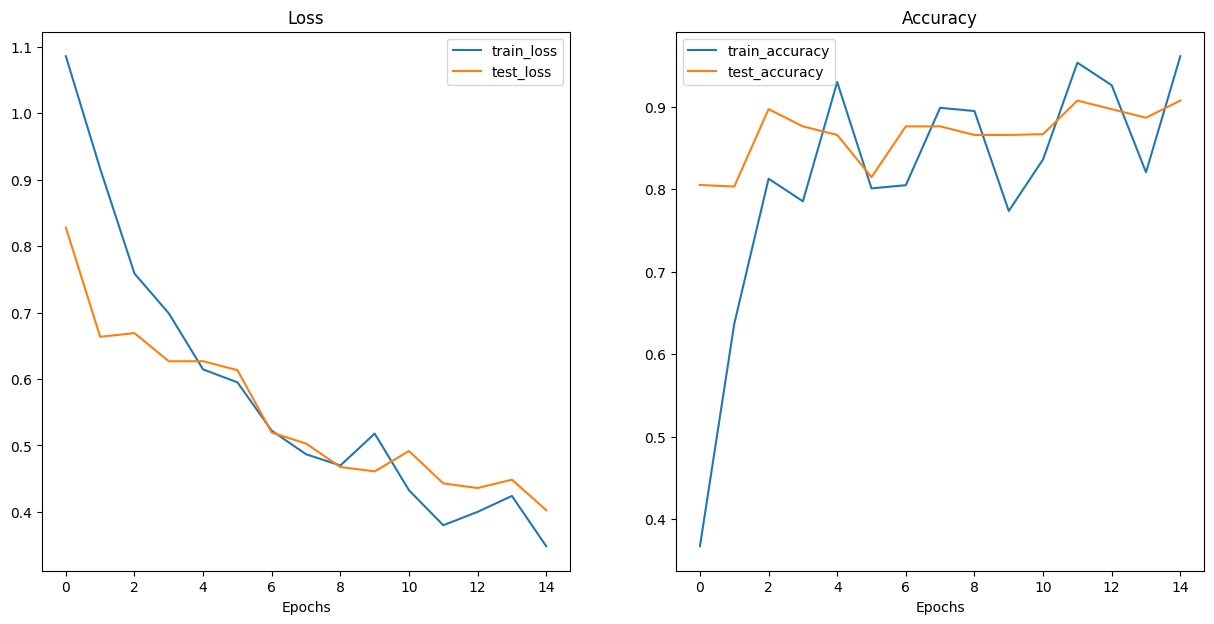

In [26]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [31]:
from typing import List, Tuple, Dict
from PIL import Image

def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str],
                        image_size:Tuple[int,int]=(224,224),
                        transform: torchvision.transforms=None,
                        device:torch.device=device):

  img=Image.open(image_path)

  if transform is not None:
    image_transform=transform
  else:
    image_transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image=image_transform(img).unsqueeze(dim=0).to(device) # Move tensor to the same device as model
    target_image_pred=model(transformed_image)
    target_image_pred_probs=torch.softmax(target_image_pred,dim=1)
    target_image_pred_label=torch.argmax(target_image_pred_probs,dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

In [33]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.6 MB/s eta 0:00:00


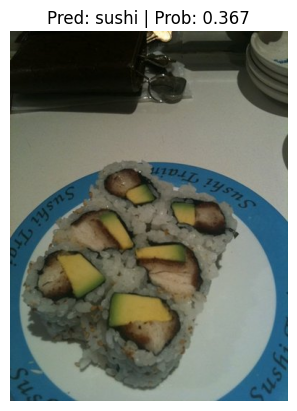

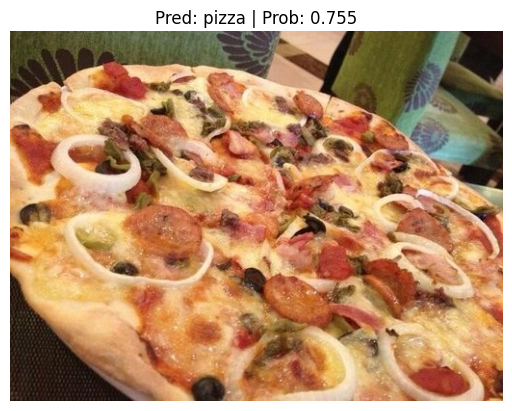

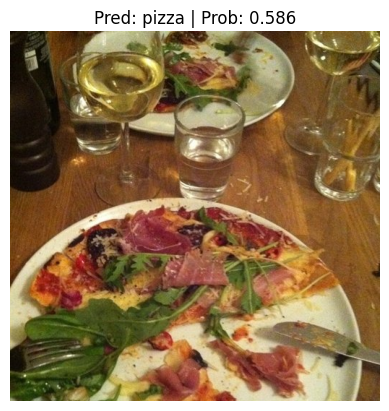

In [36]:
import random
from pathlib import Path

num_images=3
test_image_path=list(Path(test_dir).glob("*/*.jpg"))
test_image_sample=random.sample(test_image_path,k=num_images)

for image_path in test_image_sample:
    pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=classes,
                      transform=weights.transforms())

In [35]:
from modular_scripts import find_classes

In [44]:
from pathlib import Path
test_targets = [path.parent.stem for path in test_image_path]

In [55]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

y_pred_tensor=[]
model.to(device)
model.eval()
with torch.inference_mode():
  for X,y in dataload_test:
    #X,y = X.to(device), y.to(device)
    transformed_image=weights.transforms(X).unsqueeze(dim=0).to(device) # Move tensor to the same device as model
    target_image_pred=model(transformed_image)
    target_image_pred_probs=torch.softmax(target_image_pred,dim=1)
    target_image_pred_label=torch.argmax(target_image_pred_probs,dim=1)

cm = ConfusionMatrix(task="multiclass",num_classes=len(classes))
cm_tensor=cm(y_pred_tensor,test_targets)
cm_tensor

TypeError: ImageClassification.__init__() takes 1 positional argument but 2 positional arguments (and 3 keyword-only arguments) were given

In [49]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
y_pred_tensor=[]
model.eval()
with torch.inference_mode():
  for X,y in dataload_test:
    X,y=X.to(device),y.to(device)
    y_logits=model(X)
    y_prob=torch.softmax(y_logits,dim=1)
    y_pred=torch.argmax(y_prob,dim=1)
    y_pred_tensor.append(y_pred)

y_pred_tensor=torch.cat(y_pred_tensor)

cm = ConfusionMatrix(task="multiclass",num_classes=len(classes))
cm_tensor=cm(y_pred_tensor,test_targets)
cm_tensor

tensor([[23,  0,  2],
        [ 0,  1, 18],
        [ 0, 15, 16]], device='cuda:0')

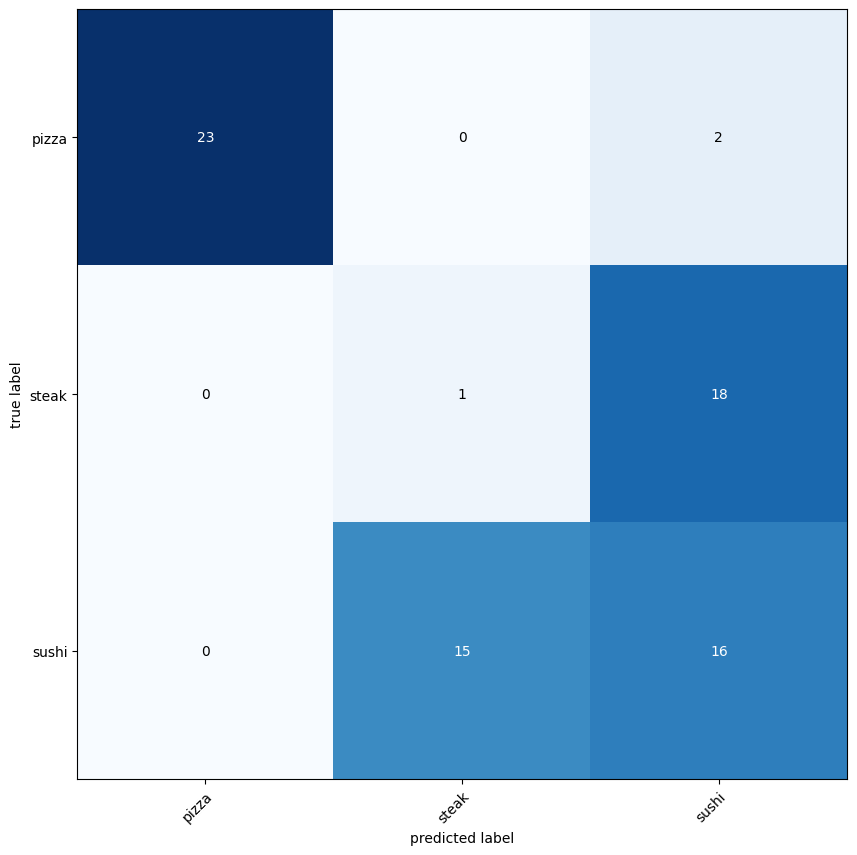

In [51]:
fig,ax=plot_confusion_matrix(
    conf_mat=cm_tensor.cpu().numpy(), # Move tensor to CPU and convert to NumPy
    class_names=classes,
    figsize=(10,10)
)